In [1]:
# import necessary pacakages
import pandas as pd
import numpy as np
from lib.neural_ode_surv import *
from lib.utils import *
import warnings
import matplotlib.pyplot as plt

# check for available GPUs
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Time to a single event prediction example : Framingham data
### Loading and pre-processing the data

In [2]:
# For more details on the dataset and covariates in Framingham data, 
# see : https://biolincc.nhlbi.nih.gov/media/teachingstudies/FHS_Teaching_Longitudinal_Data_Documentation_2021a.pdf?link_time=2022-02-03_18:20:47.023970
# this publicly available data has a person-time format for longitudinal measurements 
df_framingham = pd.read_csv('data/framingham.csv') 

# Specify categorical features
feat_cat = ['SEX', 'CIGPDAY', 'CURSMOKE','educ', 'DIABETES', 'PREVAP', 'PREVCHD', 'PREVMI', 'PREVSTRK', 'PREVHYP', 'BPMEDS']
# Specify continuous features
feat_cont = ['AGE', 'SYSBP', 'DIABP', 'TOTCHOL', 'HDLC', 'LDLC', 'BMI', 'GLUCOSE', 'HEARTRTE']
# Specify features which SurvLatent ODE is set to reconstruct
feat_reconstr = ['SYSBP', 'DIABP', 'TOTCHOL', 'HDLC', 'LDLC', 'BMI', 'GLUCOSE', 'HEARTRTE']
# Specify data_info_dic as follows 
# id_col : unique identifier for a patient
# event_col : columns correspond to event indicator; this should be binary
# time_col : column corresponds to time of measurement
# time_to_event_col : column corresponds to observed time to event (i.e. t_i = min(T_i, C_i))
# feat_cat : list containing a set of categorical features
# feat_cont : list containing a set of continuous valued features
data_info_dic = {'id_col' : 'RANDID', 'event_col' : 'DEATH', 'time_col' : 'TIME', 'time_to_event_col' : 'TIMEDTH', 'feat_cat' : feat_cat, 'feat_cont' : feat_cont}

feats_dim = len(feat_cat) + len(feat_cont)
reconstr_dim = len(feat_reconstr)
if type(data_info_dic['event_col']) == list:
    n_events = len(data_info_dic['event_col'])
else:
    n_events = 1
# Given that the Framingham study is a long follow-up study which spans about 20 years (or around 7500 days),  
# we discretize follow-up time by 10 days. Therefore, our time unit is 10-day.
df_framingham[data_info_dic['time_col']] = np.round(df_framingham[data_info_dic['time_col']].values/10)
df_framingham[data_info_dic['time_to_event_col']] = np.round(df_framingham[data_info_dic['time_to_event_col']].values/10)

# We perform 0.65-0.15-0.2 (train-valid-test) split
test_set_frac = 0.2; train_set_frac = 0.65
random_seed = 1991 # set random seed for reproducibility
np.random.seed(random_seed)

sample_ids = set(df_framingham.RANDID.values)
sample_ids_test = set(np.random.choice(list(sample_ids), size = int(len(sample_ids)*test_set_frac), replace = False))
sample_ids_train = 	set(np.random.choice(list(sample_ids - sample_ids_test), size = int(len(sample_ids - sample_ids_test)*train_set_frac/(1-test_set_frac)), replace = False))
sample_ids_valid = sample_ids - sample_ids_test - sample_ids_train

data_test = df_framingham.loc[df_framingham.RANDID.isin(sample_ids_test)].sort_values([data_info_dic['id_col'], data_info_dic['time_col']], ascending = (True, True))
data_train = df_framingham.loc[df_framingham.RANDID.isin(sample_ids_train)].sort_values([data_info_dic['id_col'], data_info_dic['time_col']], ascending = (True, True))
data_valid = df_framingham.loc[df_framingham.RANDID.isin(sample_ids_valid)].sort_values([data_info_dic['id_col'], data_info_dic['time_col']], ascending = (True, True))

# outlier processing
# We threshold outliers (i.e. feature vals < 0.005 percentile of corresponding feature vals in training set 
# AND feature vals > 0.995 percentile of corresponding features vals in training set)
feats_oi = feat_cont + ['CIGPDAY']; feat_to_min_max_dict = {}
for feat in feats_oi:
    min_feat = np.quantile(data_train[feat].dropna().values, q = 0.005)
    max_feat = np.quantile(data_train[feat].dropna().values, q = 0.995)
    data_train.loc[data_train[feat] < min_feat, feat] = min_feat
    data_train.loc[data_train[feat] > max_feat, feat] = max_feat
    feat_to_min_max_dict[feat] = (min_feat, max_feat)
    # control outliers in the valid + test co hort using training set
    data_valid.loc[data_valid[feat] < min_feat, feat] = min_feat
    data_valid.loc[data_valid[feat] > max_feat, feat] = max_feat
    data_test.loc[data_test[feat] < min_feat, feat] = min_feat
    data_test.loc[data_test[feat] > max_feat, feat] = max_feat

## Choose model hyperparameters and instantiate the model object

In [4]:
# lr : learning rate
# surv_loss_scale : determines the scaling factor for the survival loss in the total loss
# wait_until_full_surv_loss : wait # epochs until the full survival loss scaling, which allows the model to learn input representation before tuning survival estimates.
batch_size=50; lr=0.01; surv_loss_scale=100; wait_until_full_surv_loss=3; early_stopping = True;
# ODE-RNN encoder
# enc_f_nn_layers : # of layers in the neural networks function f() for learning the latent dynamics on the encoder side
# enc_latent_dim : dimensionality in the latent embedding on the encoder side
# num_units_gru : # of units in each GRU cell
enc_latent_dim=80; enc_f_nn_layers=7; num_units_gru=65; 

# Decoder 
# dec_g_nn_layers : # of layers in the neural networks function g() for learning the latent dynamics on the decoder side
# dec_latent_dim : dimensionality in the latent embedding on the decoder side
# haz_dec_layers : # of layers in the cause-specific decoder module for hazard estimation
# num_units_ode : # of units in function f() and g()
dec_g_nn_layers=3; dec_latent_dim=60; haz_dec_layers=3; num_units_ode=30; 

# Specify the prediction window to 8000 days from the entry with 10-day as a unit time
max_pred_window = 800;
n_epochs = 15; # number of training epochs

# instantiate the model :
model = SurvLatentODE(input_dim = feats_dim, reconstr_dim = reconstr_dim, dec_latent_dim = dec_latent_dim, enc_latent_dim = enc_latent_dim, enc_f_nn_layers = enc_f_nn_layers, 
                      dec_g_nn_layers = dec_g_nn_layers, num_units_ode = num_units_ode, num_units_gru = num_units_gru, device = DEVICE, n_events = n_events, haz_dec_layers = haz_dec_layers)
# set the unique identifier for the corresponding training
run_id = 'framingham_death_outcome_example_v1_1'

## Training and evaluating the model

In [5]:
# train model
model.fit(data_train, data_valid, data_info_dic, max_pred_window = max_pred_window, run_id = run_id, n_epochs = n_epochs, batch_size = batch_size, surv_loss_scale = surv_loss_scale, early_stopping = early_stopping, feat_reconstr = feat_reconstr, wait_until_full_surv_loss = wait_until_full_surv_loss, random_seed = random_seed)

Pre-processing data...: 100%|██████████| 666/666 [00:00<00:00, 22998.00it/s]
/Users/intaemoon/github/survlatent_ode/lib/utils.py



Directory 'framingham_death_outcome_example_v1_1' created
Directory 'surv_curves/framingham_death_outcome_example_v1_1/reconstruction' created


Training across 15 epochs:   7%|▋         | 57/870 [02:27<31:23,  2.32s/it]

Epoch :  1



Loading validation set...: 100%|██████████| 4/4 [00:02<00:00,  1.95it/s]




============ Validation set performance ============
survival log-likelihood :  -2107.5955
reconstr. likelihood :  0.8556
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.1648, 0.375: 0.2513, 0.5: 0.3161, 0.625: 0.3574, 0.75: 0.4456}
AUC(t) at the percentiles :  {0.25: 0.595, 0.375: 0.5713, 0.5: 0.5464, 0.625: 0.5704, 0.75: 0.5516}
mean AUC(t) over 25-75 percentile :  0.5754
Integrated BS(t) over 25-75 percentile :  0.3208




Training across 15 epochs:   7%|▋         | 58/870 [02:34<52:25,  3.87s/it]

Best iteration so far wrt. mean AUC :  1
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt




Training across 15 epochs:  13%|█▎        | 115/870 [04:56<30:22,  2.41s/it]

Epoch :  2



Loading validation set...: 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]




============ Validation set performance ============
survival log-likelihood :  -1579.8673
reconstr. likelihood :  0.8555
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0683, 0.375: 0.0988, 0.5: 0.1255, 0.625: 0.1508, 0.75: 0.172}
AUC(t) at the percentiles :  {0.25: 0.5945, 0.375: 0.5709, 0.5: 0.5473, 0.625: 0.5685, 0.75: 0.551}
mean AUC(t) over 25-75 percentile :  0.5736
Integrated BS(t) over 25-75 percentile :  0.1284




Training across 15 epochs:  13%|█▎        | 116/870 [05:03<47:10,  3.75s/it]

Best iteration so far wrt. mean AUC :  1
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt




Training across 15 epochs:  20%|█▉        | 173/870 [07:19<27:08,  2.34s/it]

Epoch :  3



Loading validation set...: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]




============ Validation set performance ============
survival log-likelihood :  -1580.3551
reconstr. likelihood :  0.8555
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0685, 0.375: 0.0991, 0.5: 0.1256, 0.625: 0.1506, 0.75: 0.1722}
AUC(t) at the percentiles :  {0.25: 0.5948, 0.375: 0.572, 0.5: 0.5534, 0.625: 0.5774, 0.75: 0.5639}
mean AUC(t) over 25-75 percentile :  0.5784
Integrated BS(t) over 25-75 percentile :  0.1285




Training across 15 epochs:  20%|██        | 174/870 [07:27<46:30,  4.01s/it]

Best iteration so far wrt. mean AUC :  3
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Storing the best model...


Training across 15 epochs:  27%|██▋       | 231/870 [09:42<25:11,  2.36s/it]

Epoch :  4



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.03it/s]




============ Validation set performance ============
survival log-likelihood :  -1571.1545
reconstr. likelihood :  0.8563
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0678, 0.375: 0.097, 0.5: 0.1228, 0.625: 0.146, 0.75: 0.1657}
AUC(t) at the percentiles :  {0.25: 0.6448, 0.375: 0.643, 0.5: 0.6615, 0.625: 0.6689, 0.75: 0.6562}
mean AUC(t) over 25-75 percentile :  0.6519
Integrated BS(t) over 25-75 percentile :  0.1248


Best iteration so far wrt. mean AUC :  4
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Storing the best model...


Training across 15 epochs:  33%|███▎      | 289/870 [12:17<24:41,  2.55s/it]

Epoch :  5



Loading validation set...: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]




============ Validation set performance ============
survival log-likelihood :  -1570.5387
reconstr. likelihood :  0.8555
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.067, 0.375: 0.0947, 0.5: 0.1196, 0.625: 0.1437, 0.75: 0.1629}
AUC(t) at the percentiles :  {0.25: 0.6766, 0.375: 0.6852, 0.5: 0.6988, 0.625: 0.6845, 0.75: 0.6638}
mean AUC(t) over 25-75 percentile :  0.6813
Integrated BS(t) over 25-75 percentile :  0.1226




Training across 15 epochs:  33%|███▎      | 290/870 [12:25<40:06,  4.15s/it]

Best iteration so far wrt. mean AUC :  5
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Storing the best model...


Training across 15 epochs:  40%|███▉      | 347/870 [14:45<20:19,  2.33s/it]

Epoch :  6



Loading validation set...: 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]




============ Validation set performance ============
survival log-likelihood :  -1587.4364
reconstr. likelihood :  0.8557
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0773, 0.375: 0.1016, 0.5: 0.1208, 0.625: 0.1393, 0.75: 0.1613}
AUC(t) at the percentiles :  {0.25: 0.7187, 0.375: 0.7229, 0.5: 0.7492, 0.625: 0.7304, 0.75: 0.7193}
mean AUC(t) over 25-75 percentile :  0.7277
Integrated BS(t) over 25-75 percentile :  0.1243




Training across 15 epochs:  40%|████      | 348/870 [14:52<33:25,  3.84s/it]

Best iteration so far wrt. mean AUC :  6
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Storing the best model...


Training across 15 epochs:  47%|████▋     | 405/870 [17:32<21:56,  2.83s/it]

Epoch :  7



Loading validation set...: 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]




============ Validation set performance ============
survival log-likelihood :  -1554.5369
reconstr. likelihood :  0.8549
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0693, 0.375: 0.099, 0.5: 0.1216, 0.625: 0.1414, 0.75: 0.1615}
AUC(t) at the percentiles :  {0.25: 0.7575, 0.375: 0.7417, 0.5: 0.7547, 0.625: 0.7466, 0.75: 0.7495}
mean AUC(t) over 25-75 percentile :  0.7502
Integrated BS(t) over 25-75 percentile :  0.1236


Best iteration so far wrt. mean AUC :  7
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Storing the best model...


Training across 15 epochs:  53%|█████▎    | 463/870 [20:35<20:35,  3.03s/it]

Epoch :  8



Loading validation set...: 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]




============ Validation set performance ============
survival log-likelihood :  -1520.6511
reconstr. likelihood :  0.8549
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0649, 0.375: 0.0907, 0.5: 0.1096, 0.625: 0.1268, 0.75: 0.1391}
AUC(t) at the percentiles :  {0.25: 0.7567, 0.375: 0.732, 0.5: 0.7577, 0.625: 0.7562, 0.75: 0.7653}
mean AUC(t) over 25-75 percentile :  0.7516
Integrated BS(t) over 25-75 percentile :  0.1106


Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Storing the best model...


Training across 15 epochs:  60%|█████▉    | 521/870 [23:34<15:29,  2.66s/it]

Epoch :  9



Loading validation set...: 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]




============ Validation set performance ============
survival log-likelihood :  -1521.8904
reconstr. likelihood :  0.8551
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0638, 0.375: 0.0884, 0.5: 0.1089, 0.625: 0.1275, 0.75: 0.1393}
AUC(t) at the percentiles :  {0.25: 0.7489, 0.375: 0.7265, 0.5: 0.754, 0.625: 0.76, 0.75: 0.7663}
mean AUC(t) over 25-75 percentile :  0.7471
Integrated BS(t) over 25-75 percentile :  0.1099




Training across 15 epochs:  60%|██████    | 522/870 [23:45<29:04,  5.01s/it]

Best iteration so far wrt. mean AUC :  8
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt




Training across 15 epochs:  67%|██████▋   | 579/870 [26:22<13:17,  2.74s/it]

Epoch :  10



Loading validation set...: 100%|██████████| 4/4 [00:03<00:00,  1.28it/s]




============ Validation set performance ============
survival log-likelihood :  -1523.48
reconstr. likelihood :  0.8547
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0665, 0.375: 0.0938, 0.5: 0.113, 0.625: 0.1295, 0.75: 0.1432}
AUC(t) at the percentiles :  {0.25: 0.771, 0.375: 0.7529, 0.5: 0.7721, 0.625: 0.773, 0.75: 0.79}
mean AUC(t) over 25-75 percentile :  0.7679
Integrated BS(t) over 25-75 percentile :  0.1137


Best iteration so far wrt. mean AUC :  10
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Storing the best model...


Training across 15 epochs:  73%|███████▎  | 637/870 [29:17<11:49,  3.04s/it]

Epoch :  11



Loading validation set...: 100%|██████████| 4/4 [00:04<00:00,  1.03s/it]




============ Validation set performance ============
survival log-likelihood :  -1526.2441
reconstr. likelihood :  0.8548
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0633, 0.375: 0.0895, 0.5: 0.1122, 0.625: 0.1327, 0.75: 0.145}
AUC(t) at the percentiles :  {0.25: 0.7453, 0.375: 0.7229, 0.5: 0.7468, 0.625: 0.7548, 0.75: 0.7752}
mean AUC(t) over 25-75 percentile :  0.7436
Integrated BS(t) over 25-75 percentile :  0.1132


Best iteration so far wrt. mean AUC :  10
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt




Training across 15 epochs:  80%|███████▉  | 695/870 [32:25<09:09,  3.14s/it]

Epoch :  12



Loading validation set...: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]




============ Validation set performance ============
survival log-likelihood :  -1517.5461
reconstr. likelihood :  0.855
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0636, 0.375: 0.0868, 0.5: 0.1077, 0.625: 0.1248, 0.75: 0.136}
AUC(t) at the percentiles :  {0.25: 0.747, 0.375: 0.7298, 0.5: 0.7576, 0.625: 0.7611, 0.75: 0.7792}
mean AUC(t) over 25-75 percentile :  0.7493
Integrated BS(t) over 25-75 percentile :  0.1079


Best iteration so far wrt. mean AUC :  10
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Training across 15 epochs:  80%|████████  | 696/870 [32:38<17:30,  6.04s/it]

Training across 15 epochs:  87%|████████▋ | 753/870 [36:00<06:49,  3.50s/it]

Epoch :  13



Loading validation set...: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]




============ Validation set performance ============
survival log-likelihood :  -1513.2214
reconstr. likelihood :  0.8549
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0648, 0.375: 0.0898, 0.5: 0.1097, 0.625: 0.1261, 0.75: 0.1354}
AUC(t) at the percentiles :  {0.25: 0.7471, 0.375: 0.7312, 0.5: 0.758, 0.625: 0.7591, 0.75: 0.7766}
mean AUC(t) over 25-75 percentile :  0.7493
Integrated BS(t) over 25-75 percentile :  0.1092


Best iteration so far wrt. mean AUC :  10
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt


Training across 15 epochs:  87%|████████▋ | 754/870 [36:16<13:59,  7.24s/it]

Training across 15 epochs:  93%|█████████▎| 811/870 [40:37<03:12,  3.26s/it]

Epoch :  14



Loading validation set...: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]




============ Validation set performance ============
survival log-likelihood :  -1514.8704
reconstr. likelihood :  0.8552
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0654, 0.375: 0.0908, 0.5: 0.1094, 0.625: 0.1262, 0.75: 0.1354}
AUC(t) at the percentiles :  {0.25: 0.7484, 0.375: 0.7293, 0.5: 0.759, 0.625: 0.759, 0.75: 0.7771}
mean AUC(t) over 25-75 percentile :  0.7498
Integrated BS(t) over 25-75 percentile :  0.1101


Best iteration so far wrt. mean AUC :  10
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt




Training across 15 epochs: 100%|█████████▉| 869/870 [43:33<00:02,  2.88s/it]

Epoch :  15



Loading validation set...: 100%|██████████| 4/4 [00:03<00:00,  1.29it/s]




============ Validation set performance ============
survival log-likelihood :  -1513.5619
reconstr. likelihood :  0.8551
remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [107 154 194 226 302]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0644, 0.375: 0.0892, 0.5: 0.1095, 0.625: 0.1254, 0.75: 0.1356}
AUC(t) at the percentiles :  {0.25: 0.7487, 0.375: 0.7239, 0.5: 0.7494, 0.625: 0.7506, 0.75: 0.7701}
mean AUC(t) over 25-75 percentile :  0.7445
Integrated BS(t) over 25-75 percentile :  0.1094




Training across 15 epochs: 100%|██████████| 870/870 [43:45<00:00,  3.02s/it]

Best iteration so far wrt. mean AUC :  10
Storing the latest model...
model_performance/framingham_death_outcome_example_v1_1/latest_model.pt




In [6]:
# load the trained model
print('Loading the trained model...')
print('run_id : ', run_id)
path = 'model_performance/' + run_id + '/best_model.pt'
try:
    model_info = get_ckpt_model(path, model, DEVICE)
except:
    raise KeyError('Model not found...')

# Process the held-out test set 
batch_dict_test = model.process_eval_data(data_test, data_info_dic, max_pred_window = max_pred_window, run_id = run_id, feat_reconstr = feat_reconstr, model_info = model_info)
# Get estimated survival probabilities
# Note : survival probs are estimated from the latest observation for each sample
# due to generative nature, surv probs may be different across runs. In this example, we set the random seed to control non-deterministic elements
surv_prob = model.get_surv_prob(batch_dict_test, model_info = model_info, max_pred_window = max_pred_window, filename_suffix = run_id, device = DEVICE, n_events = n_events)
# Evaluate the model on the held-out set and obtain model performance summary
df_test_result_comp = eval_model(model_info, batch_dict_test, surv_prob, run_id = run_id, max_pred_window = max_pred_window)

Loading the trained model...
run_id :  framingham_death_outcome_example_v1_1


Pre-processing data...: 100%|██████████| 886/886 [00:00<00:00, 9197.26it/s]


remaining time-to-event in validation/test set [25%, 37.5%, 50%, 62.5%, 75%] percentiles :  [ 97 141 182 210 271]
Performance at quantiles : 
BS(t) at the percentiles :  {0.25: 0.0649, 0.375: 0.0905, 0.5: 0.1109, 0.625: 0.1248, 0.75: 0.1416}
AUC(t) at the percentiles :  {0.25: 0.7588, 0.375: 0.7654, 0.5: 0.7698, 0.625: 0.7897, 0.75: 0.7846}
mean AUC(t) over 25-75 percentile :  0.769
Integrated BS(t) over 25-75 percentile :  0.1094


Bootstrapping...: 100%|██████████| 5000/5000 [00:45<00:00, 109.86it/s]


In [7]:
df_test_result_comp

,param_set,best_epoch,ibs,mean_auc,bs 25 percentile,bs 25 percentile se,bs 50 percentile,bs 50 percentile se,bs 75 percentile,bs 75 percentile se,auc 25 percentile,auc 25 percentile se,auc 50 percentile,auc 50 percentile se,auc 75 percentile,auc 75 percentile se
result,,,,,,,,,,,,,,,,
0,NaN,10,0.1094,0.769,0.0649,0.0058,0.1109,0.0061,0.1416,0.0059,0.7588,0.0338,0.7698,0.0227,0.7846,0.0189


## Plot estimated survival curves

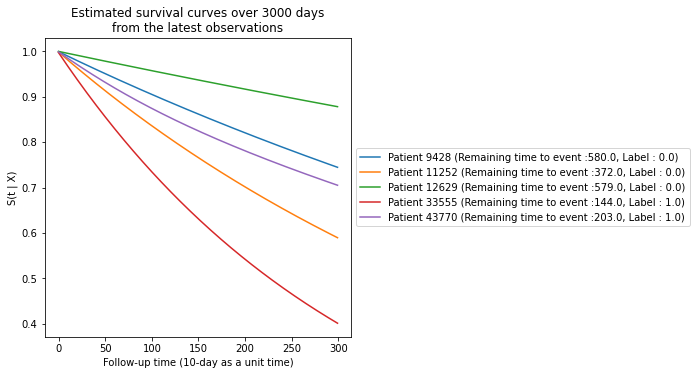

In [22]:
# Note that our prediction window is from time 0 to time 800 (i.e. 0 - 8000 days). The maximum prediction window can be made longer or shorter using 'max_pred_window'.
# Since survival probabilities are estimated from the latest observation of each patient (i.e. the latest observation is time 0 for each patient), 
# each patient has different last observation time in this case, resulting in a varying time window of estimated survival probabilities 
# For each patient, we include observed remaining time to event as well as event indicator.

sample_ids = batch_dict_test['sample_ids']
labels = batch_dict_test['labels']
remaining_time_to_event = batch_dict_test['remaining_time_to_event']

fig, axs = plt.subplots(1, 1, figsize=(5.5, 5.5))
for idx, surv_prob_ind in enumerate(surv_prob[20:25]):
    label = 'Patient ' + str(sample_ids[idx]) + ' (Remaining time to event :' + str(remaining_time_to_event[idx]) + ', Label : ' + str(labels[idx].numpy()[0]) + ')'
    axs.plot(np.arange(300), surv_prob_ind[0:300], label = label)
axs.set_title('Estimated survival curves over 3000 days\nfrom the latest observations')
axs.set_ylabel('S(t | X)')
axs.set_xlabel('Follow-up time (10-day as a unit time)')
axs.legend(bbox_to_anchor=(1,0.5), loc="center left")